In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from notebooks.problems import LinkBudgetProblem

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False
})

In [ ]:
import pandas as pd
from pymoo.algorithms.nsga2 import NSGA2
from PlotUtil import apply_report_formatting, apply_report_formatting_single

telesat_passes_df = pd.read_pickle('../Telesat_0_7day.pkl')

N_passes = 20
telesat_passes_df = telesat_passes_df[0:N_passes]

In [243]:
import numpy as np

from pymoo.optimize import minimize

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

mask = ["bin"] * N_passes + ["int"]

sampling = MixedVariableSampling(mask, {
    "bin" : get_sampling("bin_random"), 
    "int" : get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "bin": get_crossover("bin_hux"),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "bin": get_mutation("bin_bitflip"),
    "int": get_mutation("int_pm", eta=3.0)
})

Ptx_dBm = np.arange(10, 40, 5)
isend_req = 10.69

problem = LinkBudgetProblem(telesat_passes_df, N_passes, 
                            fc = 30e9, 
                            Ptx_dBm=Ptx_dBm, 
                            Gtx_dB=20, 
                            GT=13.2, 
                            B=20e6, 
                            isend_req=isend_req, 
                            Rs=16e6, 
                            eta=2.6460120)

converge_algo_settings = {'pop_size': 100, 'n_offsprings': 100}
unconverge_algo_settings = {'pop_size': 100, 'n_offsprings': 20}

converge_term_settings = {'f_tol': 0.005, 'n_max_gen': 1000, 'n_max_evals': 100000}
unconverge_term_settings =  {'f_tol': 0.005, 'n_max_gen': 100, 'n_max_evals': 2000}

converge = False
if converge:
    algo_settings = converge_algo_settings
    term_settings = converge_term_settings
    postfix = '_converged'
else:
    algo_settings = unconverge_algo_settings
    term_settings = unconverge_term_settings
    postfix = '_unconverged'

algorithm = NSGA2(
    pop_size=algo_settings['pop_size'],
    n_offsprings=algo_settings['n_offsprings'],
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)


from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    #x_tol=1e-8,
    #cv_tol=1e-6,
    f_tol=term_settings['f_tol'], #f_tol=0.005,
    nth_gen=5,
    n_last=30,
    n_max_gen=term_settings['n_max_gen'], #n_max_gen=1000,
    n_max_evals=term_settings['n_max_evals'], #n_max_evals=100000
)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               verbose=True
               )

print("Done")

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |  0.00000E+00 |  1.980000000 |       5 |            - |            - |            -
    2 |     200 |  0.00000E+00 |  0.610000000 |       9 |  0.001017156 |  0.00000E+00 |  0.085202112
    3 |     300 |  0.00000E+00 |  0.00000E+00 |      16 |  0.140073082 |  0.569400678 |  0.078788642
    4 |     400 |  0.00000E+00 |  0.00000E+00 |      22 |  0.000108865 |  0.00000E+00 |  0.011455437
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      21 |  0.062250143 |  0.871763549 |  0.011862809
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      22 |  0.000281811 |  0.00000E+00 |  0.011417074
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      25 |  0.028301887 |  0.228218787 |  0.018027177
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      26 |  0.00000E+00 |  0.00000E+00 |  0.007501815
    9 |     900 |  0.00000E+00 |  0.00000E+00 |      28 |  0.016912166 |  0.103075590 |  0.

In [244]:
import pickle
res_dump = res
# res_dump.problem = None
# res_dump.algorithm = None
# res_dump.history = None

f = open("result%s" % postfix, "wb")
pickle.dump(res_dump, f)
f.close()
print('Pickled!')

Pickled!


IndexError: index 40 is out of bounds for axis 0 with size 10

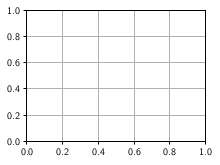

In [245]:
# Pareto fronts
from matplotlib.lines import Line2D 
import numpy as np
import matplotlib.pyplot as plt
from PlotUtil import apply_report_formatting, apply_report_formatting_single

Ptx_dBm = np.arange(10, 40, 5)
isend_req = 10.69

fig = plt.figure(figsize=(3.2, 2.4))

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_axisbelow(True)
x = res.F[:,1]
y = ((res.F[:,0] * -1) / 1e9)   # Gigabit

cmap = plt.get_cmap('tab10')
cmap = np.array(cmap.colors)

c = cmap[res.X[:,-1].tolist(),:]
ax.scatter(x, y, c=c, marker='.', s=1)

leg_lines = [Line2D([0], [0], color=cmap[i, :], lw=1) for i in np.unique(res.X[:,-1])]
leg_label = ["%.0f dBm" % Ptx_dBm[i] for i in np.unique(res.X[:,-1])]

ax.legend(leg_lines, leg_label, loc=4)

ax.set_xlabel("Energy used [J]")
ax.set_ylabel("Throughput [Gb]")
apply_report_formatting()
plt.tight_layout()
plt.show()

plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.pgf' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.svg' % postfix)
plt.close()


In [ ]:
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([0,1e9]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=3)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()
apply_report_formatting()
plt.tight_layout()

plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.svg' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.pgf' % postfix)
plt.close()

In [ ]:
# Pareto fronts
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from PlotUtil import apply_report_formatting, apply_report_formatting_single
import matplotlib.colors as mcol
import matplotlib.cm as cm

isend_req = 10.69

fig = plt.figure(figsize=(3.2, 2.4))

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_axisbelow(True)
x = res.F[:,1]
y = ((res.F[:,0] * -1) / 1e9)   # Gigabit

cm1 = mcol.LinearSegmentedColormap.from_list("BlueRed",["c","r"])
min_Ptx = min(Ptx_dBm[res.X[:,-1].tolist()])
max_Ptx = max(Ptx_dBm[res.X[1:,-1].tolist()])
cnorm = mcol.Normalize(vmin=min_Ptx,vmax=max_Ptx)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

cc = cpick.to_rgba(Ptx_dBm[res.X[:,-1].tolist()])
ax.scatter(x, y, c=cc, marker='.', s=1)

ax.set_xlabel("Energy used [J]")
ax.set_ylabel("Throughput [Gbit]")
cb = plt.colorbar(cpick,label="Power [dBm]")
cb.ax.tick_params(labelsize=8)
cb.ax.yaxis.label.set_size(8)
apply_report_formatting(4.72, 2.76)
plt.tight_layout()
plt.show()


plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.pdf' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.svg' % postfix)
plt.close()


In [ ]:
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([0,1e9]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=3)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()
apply_report_formatting_single()
plt.tight_layout()

plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.svg' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.pgf' % postfix)
plt.close()